In [1]:
# import modules
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

digits = pd.read_csv('/content/drive/MyDrive/02_Advanced Learning Algorithms/handwritten_digit_recognition/mnist_test.csv', header=None)
y_data = digits.iloc[:, 0].values.reshape(-1, 1)
x_data = digits.iloc[:, 1:].values
print("Features: \n{}".format(x_data.shape),
      "Targets: \n{}".format(y_data.shape),
      sep="\n")
dim = int(x_data.shape[1]**0.5)
print(f"Image dimension: ({dim}, {dim})")

Features: 
(10000, 784)
Targets: 
(10000, 1)
Image dimension: (28, 28)


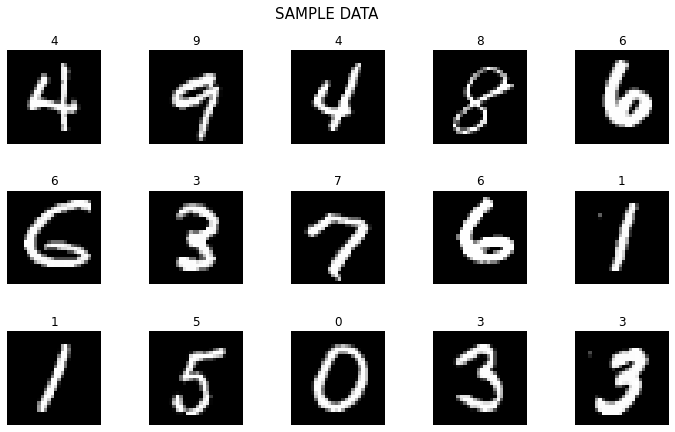

In [2]:
# x_data dimension
m, n = x_data.shape

# plot the handwritten digits
fig, axes = plt.subplots(ncols=5, nrows=3, figsize=[10, 6])
fig.tight_layout()

for ax in axes.flat:
    rand_num = np.random.randint(m) # pick random integer to select random image from x_data
    x_temp = x_data[rand_num].reshape((28, 28))
    
    # display the image
    ax.imshow(x_temp, cmap='gray')
    ax.set_title(y_data[rand_num, 0])
    ax.set_axis_off() # disable axis
fig.suptitle("SAMPLE DATA", fontsize=15, y=1.05)
fig.savefig('/content/drive/MyDrive/02_Advanced Learning Algorithms/handwritten_digit_recognition/data_examples.png', dpi=300)
plt.show()

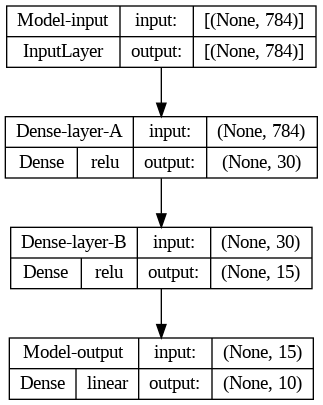

In [3]:
# develop simple neural network model
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt_func = tf.keras.optimizers.Adam(learning_rate=1e-3)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=8)

input = tf.keras.Input(shape=(784,), name='Model-input')
dense1 = tf.keras.layers.Dense(30, activation='relu', name='Dense-layer-A')(input)
dense2 = tf.keras.layers.Dense(15, activation='relu', name='Dense-layer-B')(dense1)
output = tf.keras.layers.Dense(10, activation='linear', name='Model-output')(dense2)
model = tf.keras.Model(inputs=input, outputs=output)
model.compile(optimizer=opt_func, loss=loss_func, metrics=['SparseCategoricalAccuracy'])

# plot model architecture
tf.keras.utils.plot_model(
    model, to_file='/content/drive/MyDrive/02_Advanced Learning Algorithms/handwritten_digit_recognition/model_architecture.png',
    show_shapes=True, show_layer_activations=True
)

In [4]:
# split dataset into train and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.3, random_state=42, stratify=y_data
)

In [5]:
# fit model and save the results
history = model.fit(
    x=x_train, y=y_train, batch_size=32, epochs=200, callbacks=[earlystop],
    validation_split=0.2, verbose=2
)
model.save('/content/drive/MyDrive/02_Advanced Learning Algorithms/handwritten_digit_recognition/digits_recog_model.h5')

Epoch 1/200
175/175 - 2s - loss: 8.3479 - sparse_categorical_accuracy: 0.2504 - val_loss: 2.0392 - val_sparse_categorical_accuracy: 0.3207 - 2s/epoch - 9ms/step
Epoch 2/200
175/175 - 0s - loss: 1.8521 - sparse_categorical_accuracy: 0.3407 - val_loss: 1.8211 - val_sparse_categorical_accuracy: 0.3736 - 450ms/epoch - 3ms/step
Epoch 3/200
175/175 - 1s - loss: 1.6786 - sparse_categorical_accuracy: 0.3782 - val_loss: 1.7042 - val_sparse_categorical_accuracy: 0.3950 - 501ms/epoch - 3ms/step
Epoch 4/200
175/175 - 1s - loss: 1.5768 - sparse_categorical_accuracy: 0.4143 - val_loss: 1.6231 - val_sparse_categorical_accuracy: 0.4143 - 577ms/epoch - 3ms/step
Epoch 5/200
175/175 - 0s - loss: 1.4547 - sparse_categorical_accuracy: 0.4620 - val_loss: 1.5074 - val_sparse_categorical_accuracy: 0.4457 - 485ms/epoch - 3ms/step
Epoch 6/200
175/175 - 1s - loss: 1.3264 - sparse_categorical_accuracy: 0.5139 - val_loss: 1.3710 - val_sparse_categorical_accuracy: 0.5714 - 553ms/epoch - 3ms/step
Epoch 7/200
175/175

In [6]:
# generate prediction from test data
def g_pred(x_arr, model_nn):
    y_pred = model_nn.predict(x_arr, verbose=None)
    y_prob = tf.nn.softmax(y_pred).numpy()
    m, n = y_prob.shape
    classes_np = np.zeros((m, n))
    int_classes = np.zeros((m,))
    for row in range(m):
        col = np.argmax(y_prob[row])
        int_classes[row] = col
        classes_np[row, col] = 1
    return classes_np.astype('int'), int_classes.astype('int')

preds, classes = g_pred(x_test, model)
y_test_c = pd.get_dummies(y_test.reshape(-1)).values
t_pred = []
for idx, val in enumerate(classes):
    if val==y_test[idx, 0]:
        t_pred.append(True)
    else:
        t_pred.append(False)

TRUE PREDICTIONS: 2674
FALSE PREDICTIONS: 326
PERCENTAGE: 89.13333333333334%


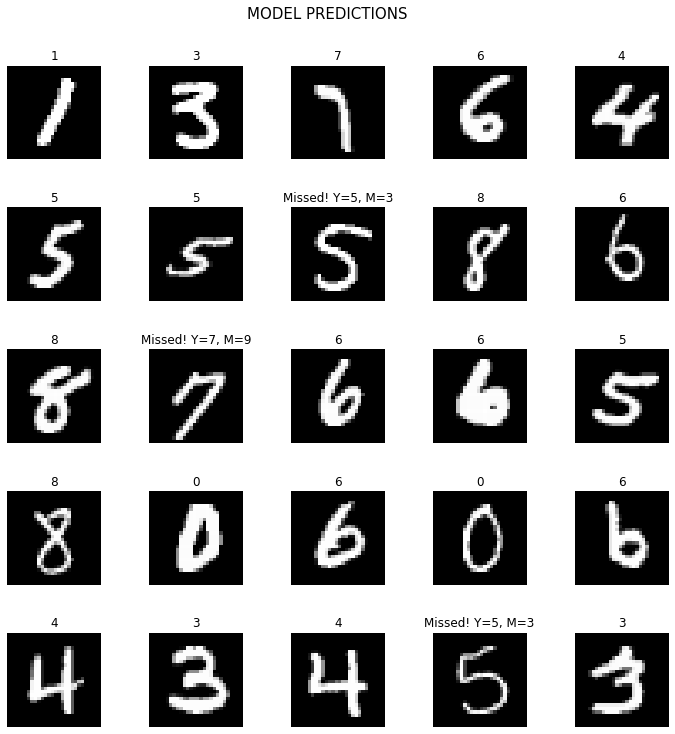

In [7]:
# test data shape
m, n = x_test.shape
perct = (100 * sum(t_pred))/m
print(f"TRUE PREDICTIONS: {sum(t_pred)}", f"FALSE PREDICTIONS: {len(t_pred)-sum(t_pred)}", f"PERCENTAGE: {perct}%", sep='\n')

# plot model prediction
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[10, 10])
fig.tight_layout()

for ax in axes.flat:
    rand_num = np.random.randint(m) # pick random integer to select random image from x_data
    x_temp = x_test[rand_num].reshape((28, 28))
    
    # display the image
    ax.imshow(x_temp, cmap='gray')
    pred_l = classes[rand_num]
    true_label = y_test[rand_num, 0]
    if pred_l != true_label:
        ax.set_title(f"Missed! Y={true_label}, M={pred_l}")
    else:
        ax.set_title(pred_l)
    ax.set_axis_off() # disable axis
fig.suptitle('MODEL PREDICTIONS', fontsize=15, y=1.05)
fig.savefig('/content/drive/MyDrive/02_Advanced Learning Algorithms/handwritten_digit_recognition/model_predictions_sample.png', dpi=300)
plt.show()